# Train a neural network model to match the X to the Y

## Author
- Name: Stefanus Bernard Melkisedek
- Bangkit ID: m741d4ky3073
- Email: stefanussipahutar@gmail.com

# Introduction

In the previous **Bangkit ILT Tech Session**, I had the opportunity to attend a class on **Mastering Unsupervised Learning** and **ANN Basics: An Overview**. This class was led by the talented instructor, [Rahmat Fajri](https://github.com/rfajri27). 

During this session, we were given an interesting challenge: _Train a neural network model to match the X to the Y_. I was drawn by this challenge, and I would tackle it using the **TensorFlow** library.

The challenge revolves around training a neural network model to match the X (input) to the Y (output). Both X and Y are sequences of numbers. The goal is for the model to predict Y given X. The model is trained using training data and evaluated with validation data. Ultimately, the model should be able to generalize well to the test data.

In [32]:
# Import the necesary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Import the custom module
import sys
sys.path.append("../scripts/")
import utility as util

In [14]:
# Defining the input array 'X'
X = np.array([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0], dtype=float)

# Defining the output array 'Y'
Y = np.array([5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0], dtype=float)

## Prepared the Dataset

### Add extra dimension to the dataset

Neural networks in TensorFlow expect input data to be in a certain shape. Specifically, they expect each input to be a tensor (a multi-dimensional array) of a certain rank (number of dimensions).

When create a `tf.data.Dataset` using `from_tensor_slices`, each element of the dataset has the same shape as the slices passed in. If `X` and `Y` are 1D arrays, then each element of the dataset will be a scalar (a 0D tensor).

However, many neural networks expect each input to be at least a 1D tensor (an array of scalars), not a scalar itself. This is because each input often represents multiple features of a data point, and each feature is a separate element in the input tensor.

By using `np.expand_dims(X, axis=-1)`, this will add an extra dimension to `X`, turning it from a 1D array of scalars into a 2D array of 1D arrays. This means that each element of the resulting dataset will be a 1D array (a tensor of rank 1), which is the shape that the neural network expects for its inputs.

The same reasoning applies to `Y`. Even though `Y` represents the target values rather than the input data, it still needs to be in the shape that the neural network expects for its targets.

So, to summarize: Why do I add an extra dimension to `X` and `Y` ? It is to ensure that each element of the dataset is in the shape that the neural network expects. If I don't do this, the neural network will raise a `ValueError` when I try to train it.

In [21]:
# Add an extra dimension to X and Y
X = np.expand_dims(X, axis=-1)
Y = np.expand_dims(Y, axis=-1)

### Creating a TensorFlow Dataset from Input and Target Arrays

When training a model in TensorFlow, the model's `fit` method expects the data to be in a certain format. Specifically, it expects a tuple of `(inputs, targets)`. 

If I just pass in the `X` array, the model wouldn't know what the corresponding target values are. It wouldn't know what it's supposed to be predicting. 

By creating a `tf.data.Dataset` using `from_tensor_slices`, I packaging the input data (`X`) and the target data (`Y`) together in the format that the model expects. Each element of the dataset is a tuple of `(input, target)`, so the model knows that for each input, there's a corresponding target that it should be predicting.

This is why I need to create a `tf.data.Dataset` from the `X` and `Y` arrays. It's all about getting the data into the format that the model expects.

In [22]:
# Create a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X, Y))

## Define Custom Callback

In [16]:
class LossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # If logs dictionary is None, initialize it as an empty dictionary
        if logs is None:
            logs = {}

        # If loss is less than a certain threshold, stop training
        if logs.get('loss') < 0.01:  
            print("\nReached 0.01 loss so cancelling training!")
            self.model.stop_training = True

## Build a Neural Network Model

### Create the Model

In [24]:
def create_uncompiled_model():
    """
    This function creates an uncompiled simple neural network model
    with two hidden layers and returns it.
    """

    # Defining a simple neural network model
    model = tf.keras.Sequential(
        [
            # Input layer with 1 input feature
            tf.keras.layers.InputLayer(shape=[1]),
            # First hidden layer with 16 neurons and ReLU activation function
            tf.keras.layers.Dense(units=32, activation="relu"),
            # Second hidden layer with 8 neurons and ReLU activation function
            tf.keras.layers.Dense(units=16, activation="relu"),
            # Output layer with 1 neuron
            tf.keras.layers.Dense(units=1),
        ]
    )

    # Returning the uncompiled model
    return model

In [25]:
# Create the Neural Network Model
model = create_uncompiled_model()

# Print the summary of the model
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609 (2.38 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

## Tune Learning rate

In [44]:
def adjust_learning_rate(training_dataset):
    """
    This function adjusts the learning rate for the model training process.
    It creates an uncompiled model, sets a learning rate schedule, compiles the model,
    and then fits the model to the provided dataset.

    Args:
        training_dataset: The dataset to be used for training the model.

    Returns:
        The history of the model training process.
    """

    # Create an uncompiled model
    model = create_uncompiled_model()

    # Define a learning rate schedule. The learning rate changes with each epoch.
    learning_rate_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-4 * 10 ** (epoch / 20)
    )

    # Select the Adam optimizer for the model
    adam_optimizer = tf.keras.optimizers.Adam()

    # Select the Huber loss for the model
    huber_loss = tf.keras.losses.Huber()

    # Select the Mean Squared Error as the metric for the model
    mse_metric = tf.keras.metrics.MeanSquaredError()

    # Compile the model with the Mean Squared Error loss, Adam optimizer, and accuracy as a metric
    model.compile(loss=huber_loss, optimizer=adam_optimizer, metrics=[mse_metric])

    # Fit the model to the dataset for 100 epochs, adjusting the learning rate according to the schedule
    training_history = model.fit(
        training_dataset, epochs=100, callbacks=[learning_rate_schedule]
    )

    return training_history

In [45]:
# Run the training with dynamic learning rate
learning_rate_history = adjust_learning_rate(dataset)

Epoch 1/100


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.7002 - mean_squared_error: 58.4438 - learning_rate: 1.0000e-04
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6679 - mean_squared_error: 58.0558 - learning_rate: 1.1220e-04
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6367 - mean_squared_error: 57.6755 - learning_rate: 1.2589e-04
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6021 - mean_squared_error: 57.2553 - learning_rate: 1.4125e-04
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5631 - mean_squared_error: 56.7859 - learning_rate: 1.5849e-04
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5190 - mean_squared_error: 56.2605 - learning_rate: 1.7783e-04
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4691 - mean_squared_error: 55.6726 - learning_rate: 1.9953e-04
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4127 - mean_squared_error: 55.0168 - learning_rate: 2.2387e-04
Epoch 9/100
10/10 ━━

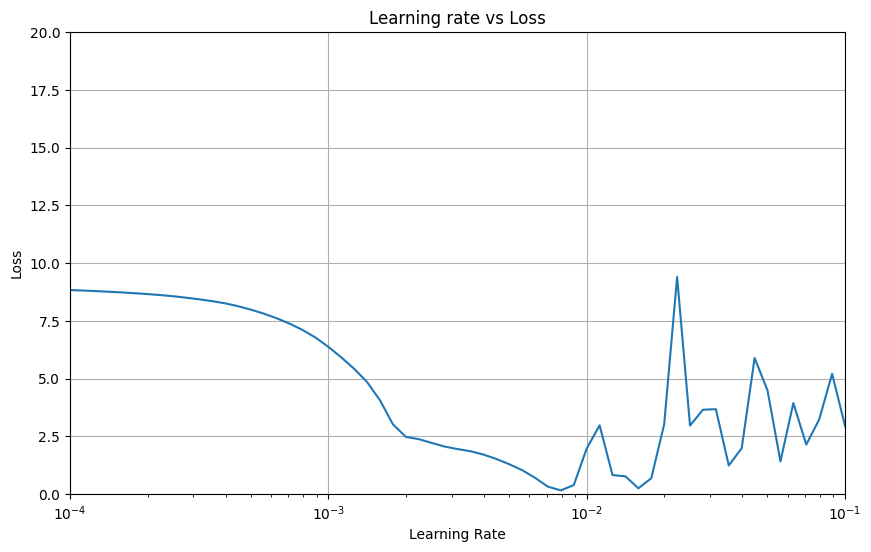

In [46]:
# Define variables for learning rate and loss
learning_rate = learning_rate_history.history["learning_rate"]
loss = learning_rate_history.history["loss"]

# Define axis limits
x_axis_limits = [1e-4, 1e-1]
y_axis_limits = [0, 20]

# Create a new figure with a specified size
plt.figure(figsize=(10, 6))

# Enable grid
plt.grid(True)

# Plot learning rate vs loss with a logarithmic scale on the x-axis
plt.semilogx(learning_rate, loss)

# Set the limits of the x and y axes
plt.axis(x_axis_limits + y_axis_limits)

# Set the title of the plot
plt.title('Learning rate vs Loss')

# Label the x and y axes
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

# Display the plot
plt.show()

Based on the graph above, I would like to choose the learning rate of 5e-2 for training the model.

### Compile the Model

In [ ]:
model.compile(optimizer='sgd', loss='mean_squared_error')

In [ ]:
model.fit(X, Y, epochs=500)

Epoch 1/500
1/1 [==============================] - 0s 435ms/step - loss: 110.6602
Epoch 2/500
1/1 [==============================] - 0s 15ms/step - loss: 97.0252
Epoch 3/500
1/1 [==============================] - 0s 10ms/step - loss: 86.8461
Epoch 4/500
1/1 [==============================] - 0s 9ms/step - loss: 79.0747
Epoch 5/500
1/1 [==============================] - 0s 9ms/step - loss: 72.9887
Epoch 6/500
1/1 [==============================] - 0s 9ms/step - loss: 68.0904
Epoch 7/500
1/1 [==============================] - 0s 10ms/step - loss: 64.0362
Epoch 8/500
1/1 [==============================] - 0s 10ms/step - loss: 60.5889
Epoch 9/500
1/1 [==============================] - 0s 14ms/step - loss: 57.5842
Epoch 10/500
1/1 [==============================] - 0s 12ms/step - loss: 54.9082
Epoch 11/500
1/1 [==============================] - 0s 11ms/step - loss: 52.4816
Epoch 12/500
1/1 [==============================] - 0s 8ms/step - loss: 50.2489
Epoch 13/500
1/1 [=====================

In [ ]:
model.predict([4, 5]).round()

1/1 [==============================] - 0s 218ms/step


array([[13.],
       [14.]], dtype=float32)